In [8]:
from twitter_scraper import settings
from twitter_scraper.clean.users import USER_DTYPE
from twitter_scraper.clean.tweets import TWEET_DTYPE

import matplotlib.pyplot as plt
import pandas as pd

users_df = pd.read_csv(settings.CLEAN_USERS_CSV, dtype=USER_DTYPE)
tweets_df = pd.read_csv(settings.CLEAN_TWEETS_CSV, dtype=TWEET_DTYPE)

In [25]:
print("Earliest Tweet date:", tweets_df['created_at'].min().date)
print("Latest Tweet date:", tweets_df['created_at'].min().date)

AttributeError: 'str' object has no attribute 'date'

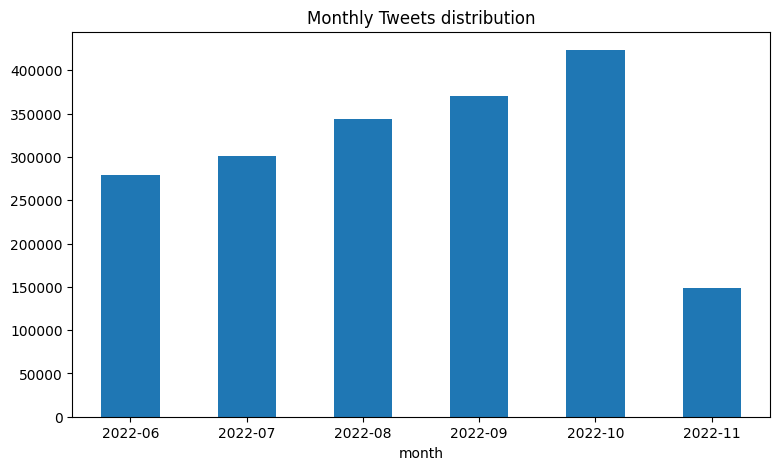

In [22]:
fig, ax = plt.subplots(1, figsize=(9, 5))

tweets_df.groupby('month').size() \
  .plot(
    kind='bar',
    title='Monthly Tweets distribution',
    rot=0,
    ax=ax
  )
plt.show()

In [6]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865058 entries, 0 to 1865057
Data columns (total 27 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   id                         int64  
 1   user_id                    int64  
 2   user_id_str                int64  
 3   full_text                  string 
 4   created_at                 object 
 5   hashtags                   object 
 6   user_mentions              object 
 7   retweet_count              int64  
 8   retweet_from_user_id       Int64  
 9   retweet_from_tweet_id      Int64  
 10  retweet_created_at         object 
 11  in_reply_to_status_id      Int64  
 12  in_reply_to_status_id_str  float64
 13  in_reply_to_user_id        Int64  
 14  in_reply_to_user_id_str    float64
 15  in_reply_to_screen_name    object 
 16  is_quote_status            bool   
 17  favorite_count             int64  
 18  favorited                  bool   
 19  retweeted                  bool   
 20  po

In [ ]:
retweet_view = tweets_df[[
    'id', 
    'user_id', 
    'created_at', 
    'full_text', 
    'retweet_from_user_id', 
    'retweet_from_tweet_id', 
    'retweet_created_at'
]].rename(columns={
    'id':                   'rt_tweet_id', 
    'user_id':              'rt_user_id', 
    'created_at':           'rt_created_at', 
    'full_text':            'full_text', 
    'retweet_created_at':   'og_created_at',
    'retweet_from_user_id': 'og_user_id', 
    'retweet_from_tweet_id': 'og_tweet_id'
}).merge()

In [7]:
tweets_df.groupby('user_id').size()
# .agg(total_tweets=('user_id', 'size')).join(user_df.set_index('user_id'), how='inner')

user_id
7331                     37
11705                    10
12667                   115
664493                    4
680383                 1865
                       ... 
1545073893769101313    1527
1547452516060860418     196
1548749502030430208    1799
1550232029425459201     286
1550806077339566081     216
Length: 9299, dtype: int64